In [94]:
# Botorch and Ax imports.
from ax import json_load
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.core.observation import ObservationFeatures
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from ax.service.utils.report_utils import exp_to_df

# Other library imports.
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [134]:
# Path to BoTorch experiment.
exp_fp = r"C:\Users\ayoun\Box\Research\Flood_Sim_Materials\BayesOpt_Paper\Data\Roughness_Output\BT_exp_c2s3.json"

# Load the experiment.
exp = json_load.load_experiment(exp_fp)

# Extract parameters.
pars = list(exp.parameters.values())

# Extract into DataFrame
results_df = exp_to_df(exp)
results_df.head()

,_run_with_loss,trial_index,arm_name,veg1_n_g,veg2_n_g,trial_status,generation_method
0,-0.004771,0,0_0,0.066599,0.188578,COMPLETED,Sobol
1,-0.005845,0,0_1,0.141566,0.041576,COMPLETED,Sobol
2,-0.011340,0,0_2,0.190289,0.137229,COMPLETED,Sobol
3,-0.000444,0,0_3,0.040091,0.081763,COMPLETED,Sobol
4,-0.000941,0,0_4,0.052122,0.112800,COMPLETED,Sobol


In [135]:
# Create a model with the experiment.
gp_model = Models.BOTORCH_MODULAR(
                experiment=exp,
                surrogate=Surrogate(SingleTaskGP),
                data=exp.eval(),
                botorch_acqf_class=qNoisyExpectedImprovement
            )

In [136]:
# Predict on a grid.
ngrid = 50
ndim = len(pars)

param_x = []
for i, param in enumerate(pars):
    param_x.append(np.linspace(param.lower, param.upper, ngrid))
    
xlin = [x for x in param_x]
Xgrid = np.meshgrid(*xlin)

# Flatten the meshgrid into ndim columns.
X = np.array([Xgrid[i].flatten() for i in range(ndim)]).T

# Make the observation features.
obs_feats = []
x_names = [p.name for p in pars]
for row in range(X.shape[0]):
    Xrow = X[row,:]
    param_dict = {x_names[i]: Xrow[i] for i in range(len(Xrow))}
    obs_feats.append(ObservationFeatures(parameters=param_dict))

# Predict on the grid.
fg, cov = gp_model.predict(obs_feats)
model_name = list(fg.keys())[0]
fg = np.array(fg[model_name]).reshape(Xgrid[0].shape)
cov = np.array(cov[model_name][model_name]).reshape(Xgrid[0].shape)

In [137]:
def interp_x_to_data(data_x, data_y, x):
    """
    Finds the y-value that corresponds to a linear interpolation of the data.
    """
    f = scipy.interpolate.interp1d(data_x, data_y)
    y = f(x)
    
    return y

(50, 50)


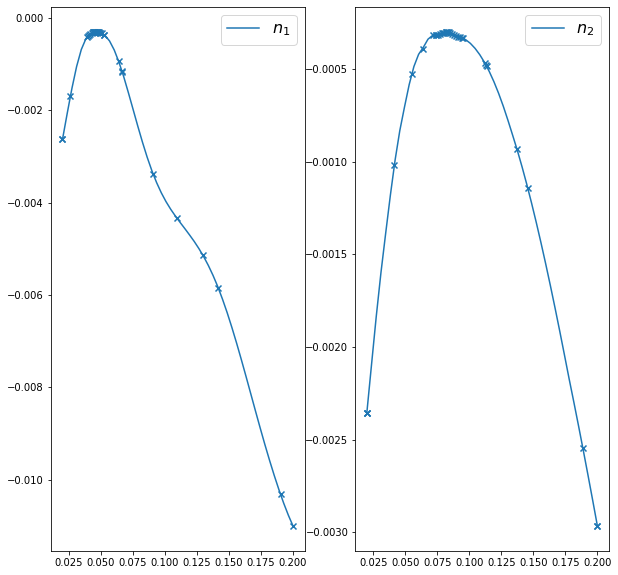

In [138]:
p_idx = 0

# Find the skyline of best points for each parameter value.
fg_best = []
for i in range(ngrid):
    param_loc = param_x[p_idx][i]
    
    # Get values of fg where the parameter is equal to the current search value.
    fg_search = fg[Xgrid[p_idx] == param_loc]
    fg_best.append(max(fg_search))

print(fg.shape)
# fig, ax = plt.subplots()
# # ax.scatter(Xgrid[p_idx], fg)
# ax.plot(param_x[p_idx], fg_best)

# Plot marginal distributions on grid.
Tot = len(Xgrid)
Cols = 2

# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(figsize=(10,10))
for k in range(Tot):

    # add every single subplot to the figure with a for loop
    # Find the skyline of best points for each parameter value.
    fg_best = []
    for i in range(ngrid):
        param_loc = param_x[k][i]

        # Get values of fg where the parameter is equal to the current search value.
        fg_search = fg[Xgrid[k] == param_loc]
        fg_best.append(max(fg_search))
        
    # Scatter plot sampling locations along each line.
    x_name = x_names[k]
    sample_x = results_df.loc[:,x_name]
    
    sample_y = interp_x_to_data(param_x[k], fg_best, sample_x)

    ax1 = fig.add_subplot(Rows,Cols,Position[k])
    ax1.plot(param_x[k], fg_best, label=f'$n_{k+1}$')
    ax1.scatter(sample_x, sample_y, marker='x')
    ax1.legend(fontsize=16)
    
plt.show()



# MARGINALIZATION, BUT DOES NOT HELP WITH ANALYSIS

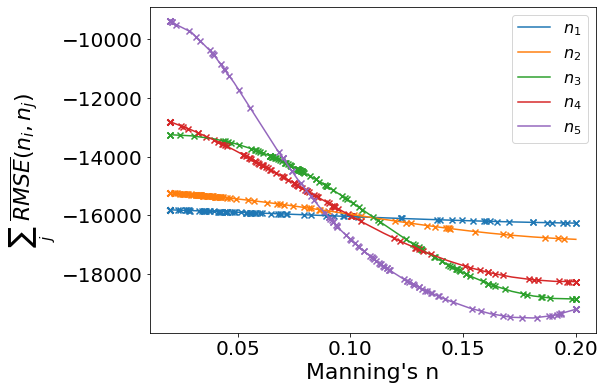

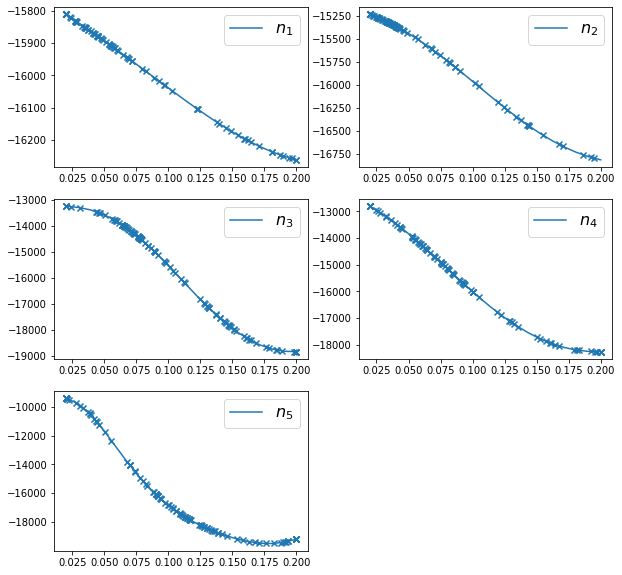

In [55]:
# Marginalize over each dimension.
dims = list(range(ndim-1,-1,-1))
marginal_funcs = []
for i in dims:
    # Dimensions to marginalize out.
    marg_dim = dims.copy()
    marg_dim.remove(i)
    
    f = np.squeeze(np.apply_over_axes(np.sum, fg, marg_dim))
    marginal_funcs.append(f)
    

# Plot marginal distributions on same plot.
fig, ax = plt.subplots(figsize=(8,6))
for i in range(ndim):
    a = ax.plot(param_x[i], marginal_funcs[i], label=f'$n_{i+1}$')
    
    # Scatter plot sampling locations along each line.
    x_name = x_names[i]
    sample_x = results_df.loc[:,x_name]
    
    sample_y = interp_x_to_data(param_x[i], marginal_funcs[i], sample_x)
    ax.scatter(sample_x, sample_y, marker='x', c=a[0].get_color())
    
ax.legend(fontsize=16)
ax.set_xlabel("Manning's n", fontsize=22)
ax.set_ylabel('$\sum_j \ \overline{RMSE}(n_i,n_j)$',  fontsize=22)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


# Plot marginal distributions on grid.
Tot = 5
Cols = 2

# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(figsize=(10,10))
for k in range(Tot):
    
    # Scatter plot sampling locations along each line.
    x_name = x_names[k]
    sample_x = results_df.loc[:,x_name]
    
    sample_y = interp_x_to_data(param_x[k], marginal_funcs[k], sample_x)

    # add every single subplot to the figure with a for loop

    ax1 = fig.add_subplot(Rows,Cols,Position[k])
    ax1.plot(param_x[k], marginal_funcs[k], label=f'$n_{k+1}$')
    ax1.scatter(sample_x, sample_y, marker='x')
    ax1.legend(fontsize=16)


plt.show()

# fig, ax = plt.subplots(2,2, figsize=(10,8))
# for i in range(ndim):
#     ax[i].plot(param_x[i], marginal_funcs[i], label=f'$n_{i+1}$')
    
#     ax[i].legend(fontsize=16)
#     ax[i].set_xlabel("Manning's n", fontsize=22)
#     ax[i].set_ylabel('$\sum_j \ \overline{RMSE}(n_i,n_j)$', fontsize=22)
#     ax[i].tick_params(axis='x', labelsize=20)
#     ax[i].tick_params(axis='y', labelsize=20)